We'll continue where we left off in the last post, trying to recreate <b style="color:#EB1960">Figure 5</b> from a paper by @ovarian-cancer-living-biobank.

![<b style="color:#EB1960">Figure 5</b>.  Not my own work](./images/ovarian-fig5.png)

This time, we'll focus on <b style="color:#EB1960">Figure 5b</b>, which entails deciding whether a cell is <b style="color:#A6A440">stromal</b> or <b style="color:#A6A440">tumour</b>.

> <b style="color:#EB1960">5b)</b> Dot plots quantitating the percentage of cells in the <b style="color:#EB1960">stromal</b> and <b style="color:#EB1960">tumour</b> clusters. Line represents the mean (N = 4 biological independent samples i.e. n = 1 for each of the four <b style="color:#A6A440">OCMsM</b>).
>
> -- @ovarian-cancer-living-biobank

# Loading the Data

To get started, we'll load in our data and then create a `SingleCellExperiment` class from the eponymous `SingleCellExperiment` package.  This is a dependency of `scran` and `scater` which were installed in the last post; so we'll go ahead and the latter two (and we'll explicitly load `SingleCellExperiment` this time for clarity).

In [ ]:
# For reproducibility
set.seed(0)

In [ ]:
library(SingleCellExperiment)
library(scran)
library(scater)

In [ ]:
counts.mat <- Matrix::readMM('./localdata/ovarian-cancer-hgv-counts.mtx')

In [ ]:
counts.rows <- read.csv('./localdata/ovarian-cancer-hgv-rows.csv', sep=',')[,-1]
counts.cols <- read.csv('./localdata/ovarian-cancer-hgv-columns.csv', sep=',')[,-1]
counts.meta <- read.csv('./localdata/ovarian-cancer-hgv-metadata.csv', sep=',')[,-1]

In [ ]:
rownames(counts.mat) <- counts.rows
colnames(counts.mat) <- counts.cols

From documentation, it seems like the convention is to abbreviate `SingleCellExperiment` as `sce`, so we'll name our data`ovarian.sce`.

In [ ]:
ovarian.sce <- SingleCellExperiment(
    assays=list(counts=counts.mat),
)

In [ ]:
# Add patient metadata
ovarian.sce$patient <- counts.meta$Sample.Characteristic.individual.

In [ ]:
# Take a peak at internal structure
ovarian.sce

class: SingleCellExperiment 
dim: 6454 18757 
metadata(0):
assays(1): counts
rownames(6454): ENSG00000000457 ENSG00000000460 ... ENSG00000288504
  ENSG00000288649
rowData names(0):
colnames(18757): SAMEA6492740-AAACCCACAGTTAGGG
  SAMEA6492740-AAACCCACATGTGTCA ... SAMEA6492743-TTTGTTGGTCCTGGTG
  SAMEA6492743-TTTGTTGTCAGATTGC
colData names(1): patient
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

While R somewhat markets itself as a functional^[In the sense of "functional programming"] language^[Although it does allow for non-functional styles too], the way data is used tends to look a tad imperative.  We'll be writing a lot of lines that look like:

```{R}
ovarian.sce <- f(ovarian.sce)
```

Which, yeah, is genuinely functional:
```{R}
# This does not change `ovarian.sce`
ovarian.sce.f <- f(ovarian.sce)
```

But it feels like it's functional being used with an imperative mindset 😅.  It feels a bit weird to me! But it's not a big deal.

Let's take the log of our data.  We'll use `logNormCounts` from the `scuttle` package^[already loaded as a dependency of either `scran` or `scatter`, I have no idea which.].  This will have the side effect of normalizing our data, but since our data was already normalized I don't think this will cause a problem?  🤷‍♂️ I'm just being quick and dirty here to get some experience using the `SingleCellExperiment` class, we saw an example of manually normalizing in the last blog post so we won't worry too much here.

In [ ]:
ovarian.sce <- scuttle::logNormCounts(ovarian.sce)

We can see that we now have a new <b style="color:#A6A440">assay</b>, `logcounts`, as well as more `colData` "`sizeFactor`".  The latter is the value we used to scale counts for normalization.

In [ ]:
ovarian.sce

class: SingleCellExperiment 
dim: 6454 18757 
metadata(0):
assays(2): counts logcounts
rownames(6454): ENSG00000000457 ENSG00000000460 ... ENSG00000288504
  ENSG00000288649
rowData names(0):
colnames(18757): SAMEA6492740-AAACCCACAGTTAGGG
  SAMEA6492740-AAACCCACATGTGTCA ... SAMEA6492743-TTTGTTGGTCCTGGTG
  SAMEA6492743-TTTGTTGTCAGATTGC
colData names(2): patient sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [ ]:
colData(ovarian.sce)

DataFrame with 18757 rows and 2 columns
                                  patient sizeFactor
                              <character>  <numeric>
SAMEA6492740-AAACCCACAGTTAGGG         38b   1.127861
SAMEA6492740-AAACCCACATGTGTCA         38b   1.110393
SAMEA6492740-AAACCCAGTCGCATGC         38b   1.701412
SAMEA6492740-AAACCCAGTCTTTCAT         38b   1.058486
SAMEA6492740-AAACCCATCCGTGTCT         38b   0.586412
...                                   ...        ...
SAMEA6492743-TTTGGTTTCATCGTAG          79   1.364770
SAMEA6492743-TTTGTTGCAACCGACC          79   0.249135
SAMEA6492743-TTTGTTGGTCAGTCCG          79   1.374554
SAMEA6492743-TTTGTTGGTCCTGGTG          79   1.357728
SAMEA6492743-TTTGTTGTCAGATTGC          79   1.021525

Since <b style="color:#EB1960">Figue 5b</b> is dependent on knowing the <b style="color:#A6A440">tumor</b> and <b style="color:#A6A440">stromal</b> cells, which were deduced using <b style="color:#537FBF">tSNE</b> by @ovarian-cancer-living-biobank, we'll get set up with that as well.

In [ ]:
# They only ran tSNE on the first 14 dimensions of PCA-transformed data.
# The `assay.type` defaults to "logcounts" but I wanted to be explicit
# since it's not obvious that it would (although it is sensible that it does).
tryCatch(
    ovarian.sce <- scran::fixedPCA(
        ovarian.sce,
        rank=14,
        subset.row=NULL,
        assay.type="logcounts"
    ),
    error=function(e){print(e)}
)

<simpleError in MatrixGenerics:::.load_next_suggested_package_to_search(x): Failed to find a colVars() method for dgTMatrix objects.>


This error is a nuisance, but it seems like it's an issue with `dgTMatrix` being for <strong style="color:#C0CF96">dweebs</strong>.  We should use `dgCMatrix` instead ([thanks internet!](https://support.bioconductor.org/p/100954/)).

In [ ]:
# Convert assays to dgCMatrix
assay(ovarian.sce, "counts") <- as(
    assay(ovarian.sce, "counts"),
    "CsparseMatrix"
)
assay(ovarian.sce, "logcounts") <- as(
    assay(ovarian.sce, "logcounts"),
    "CsparseMatrix"
)

In [ ]:
ovarian.sce <- scran::fixedPCA(
    ovarian.sce,
    rank=14,
    subset.row=NULL,
    assay.type="logcounts"
)

In [ ]:
ovarian.sce <- scater::runTSNE(
    ovarian.sce,
    dimred="PCA"
)

In [ ]:
ovarian.sce

class: SingleCellExperiment 
dim: 6454 18757 
metadata(0):
assays(2): counts logcounts
rownames(6454): ENSG00000000457 ENSG00000000460 ... ENSG00000288504
  ENSG00000288649
rowData names(0):
colnames(18757): SAMEA6492740-AAACCCACAGTTAGGG
  SAMEA6492740-AAACCCACATGTGTCA ... SAMEA6492743-TTTGTTGGTCCTGGTG
  SAMEA6492743-TTTGTTGTCAGATTGC
colData names(2): patient sizeFactor
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):

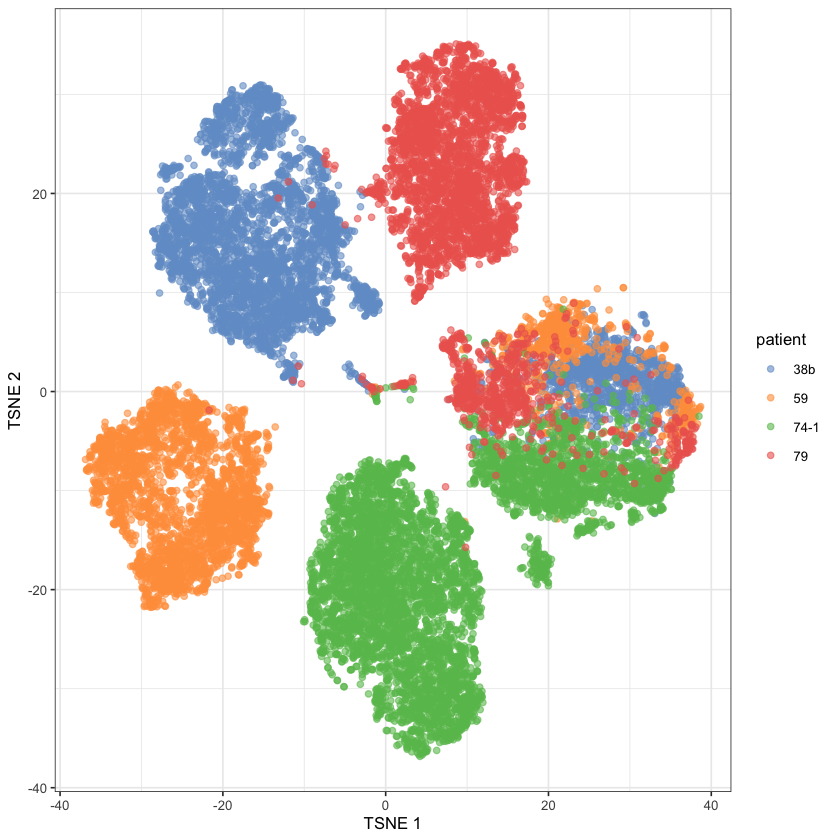

In [ ]:
plotReducedDim(ovarian.sce, dimred="TSNE", colour_by="patient")

:::{.column-margin}
This looks much better than last post...  Which probably means I made a mistake with the normalization somewhere there 😬 
:::

# Identifying <b style="color:#A6A440">stromals</b>

The paper claims that the <b style="color:#A6A440">tumor</b> cells are the ones in the single-patient clusters and the <b style="color:#A6A440">stromal</b> cells are the ones in the multi-patient cluster.  To partition them ourself, we need a clustering method!  We'll do `scran::clusterCells` because `scran` hasn't failed us yet.

In [ ]:
ovarian.sce$tumor.stromal.clusters <- scran::clusterCells(
    ovarian.sce,
    use.dimred="TSNE"
)

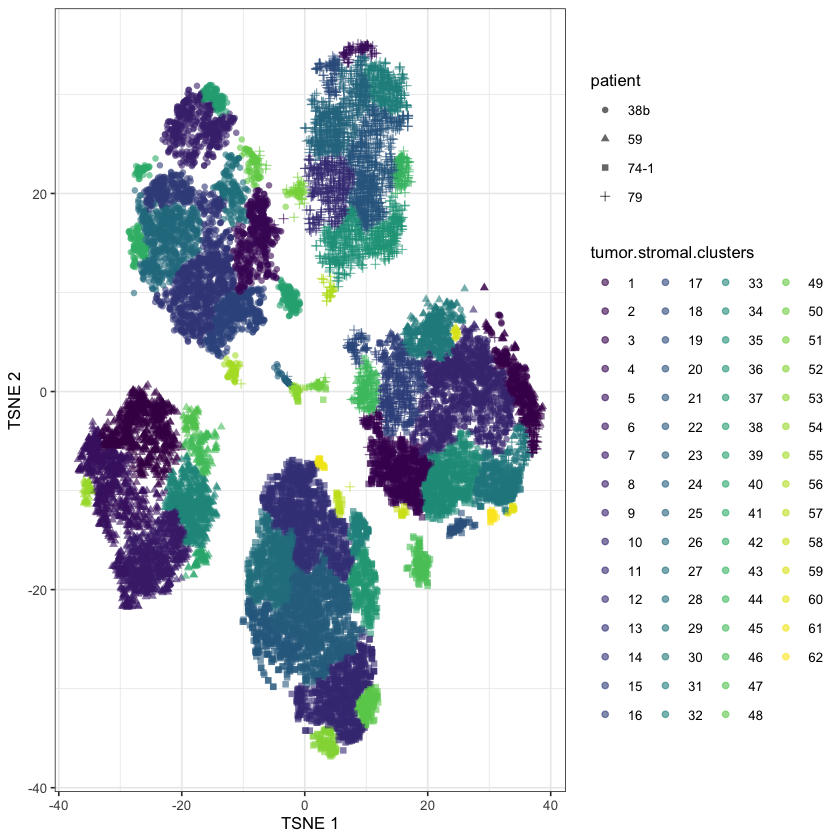

In [ ]:
plotReducedDim(
    ovarian.sce,
    "TSNE",
    colour_by="tumor.stromal.clusters",
    shape_by="patient"
)

Annoyingly, this is way too many clusters!  So we'll have to tune the parameters a bit.

In [ ]:
# This library is needed to specify graph parameters
library(bluster)

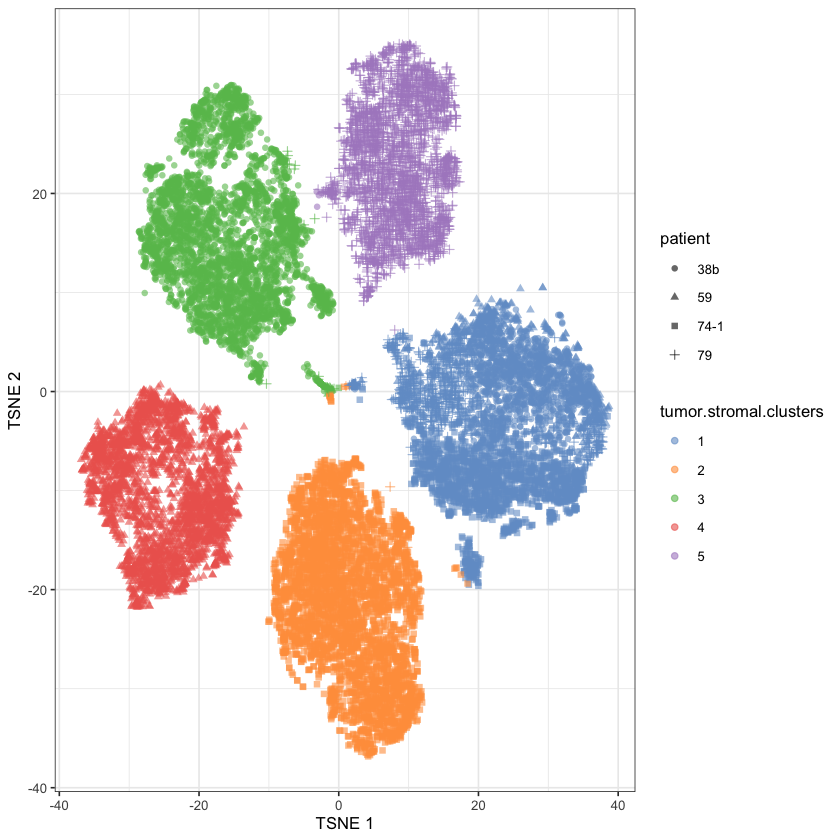

In [ ]:
ovarian.sce$tumor.stromal.clusters <- scran::clusterCells(
    ovarian.sce,
    use.dimred="TSNE",
    BLUSPARAM=bluster::KmeansParam(centers=5)
)
plotReducedDim(
    ovarian.sce,
    "TSNE",
    colour_by="tumor.stromal.clusters",
    shape_by="patient"
)

There we go!  It seems that either Cluster 1 or 5 is the cluster we want to remove - it's hard for me to tell because I'm colorblind^[I should have thought of that before making the graph...].  So let's see how heterogenous the candidate clusters are:

In [ ]:
unique(ovarian.sce[,ovarian.sce$tumor.stromal.clusters==1]$patient)
unique(ovarian.sce[,ovarian.sce$tumor.stromal.clusters==5]$patient)

[1] "38b"  "59"   "74-1" "79"

[1] "38b" "79"

It seems clear that <b style="color:#C0CF96">Cluster 1</b> is our heterogenous cluster, and hence represents our <b style="color:#A6A440">stromal cells</b>.

In [ ]:
stromal.index <- ovarian.sce$tumor.stromal.clusters==1

# <b style="color:#EB1960">Fig 5b</b>

To make <b style="color:#EB1960">Fig 5b</b>, we just need to now know the relative proportions of <b style="color:#A6A440">tumor</b> and <b style="color:#A6A440">stromal</b> cells on a per-patient level.

In [ ]:
patient.38b.index <- ovarian.sce$patient=='38b'
patient.59.index <- ovarian.sce$patient=='59'
patient.74_1.index <- ovarian.sce$patient=='74-1'
patient.79.index <- ovarian.sce$patient=='79'

In [ ]:
# Get raw amount for each patient
stromal.amount <- colSums(data.frame(
    patient.38b=patient.38b.index & stromal.index,
    patient.59=patient.59.index & stromal.index,
    patient.74_1=patient.74_1.index & stromal.index,
    patient.79=patient.79.index & stromal.index
))
tumor.amount <- colSums(data.frame(
    patient.38b=patient.38b.index & !stromal.index,
    patient.59=patient.59.index & !stromal.index,
    patient.74_1=patient.74_1.index & !stromal.index,
    patient.79=patient.79.index & !stromal.index
))

In [ ]:
# Calculate the percents
tumor.stromal.data <- data.frame(stromal.amount, tumor.amount)
tumor.stromal.data$patient <- rownames(tumor.stromal.data)
tumor.stromal.data$stromal.percent <- (
    tumor.stromal.data$stromal.amount / (
        tumor.stromal.data$stromal.amount + tumor.stromal.data$tumor.amount
    )
)
tumor.stromal.data$tumor.percent <- (
    tumor.stromal.data$tumor.amount / (
        tumor.stromal.data$stromal.amount + tumor.stromal.data$tumor.amount
    )
)
tumor.stromal.data

,stromal.amount,tumor.amount,patient,stromal.percent,tumor.percent
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
patient.38b,1230,3976,patient.38b,0.2362658,0.7637342
patient.59,693,3003,patient.59,0.1875000,0.8125000
patient.74_1,1854,4111,patient.74_1,0.3108131,0.6891869
patient.79,849,3041,patient.79,0.2182519,0.7817481


In [ ]:
# Format it to work in `geom_dotplot`
tumor.stromal.data.for.dotplot <- data.frame(
    percent=as.integer(
        c(tumor.stromal.data$stromal.percent, tumor.stromal.data$tumor.percent) * 100
    ),
    tumor.stromal=c("S", "S", "S", "S", "T", "T", "T", "T")
)
tumor.stromal.data.for.dotplot

percent,tumor.stromal
<int>,<chr>
23,S
18,S
31,S
21,S
76,T
81,T
68,T
78,T


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


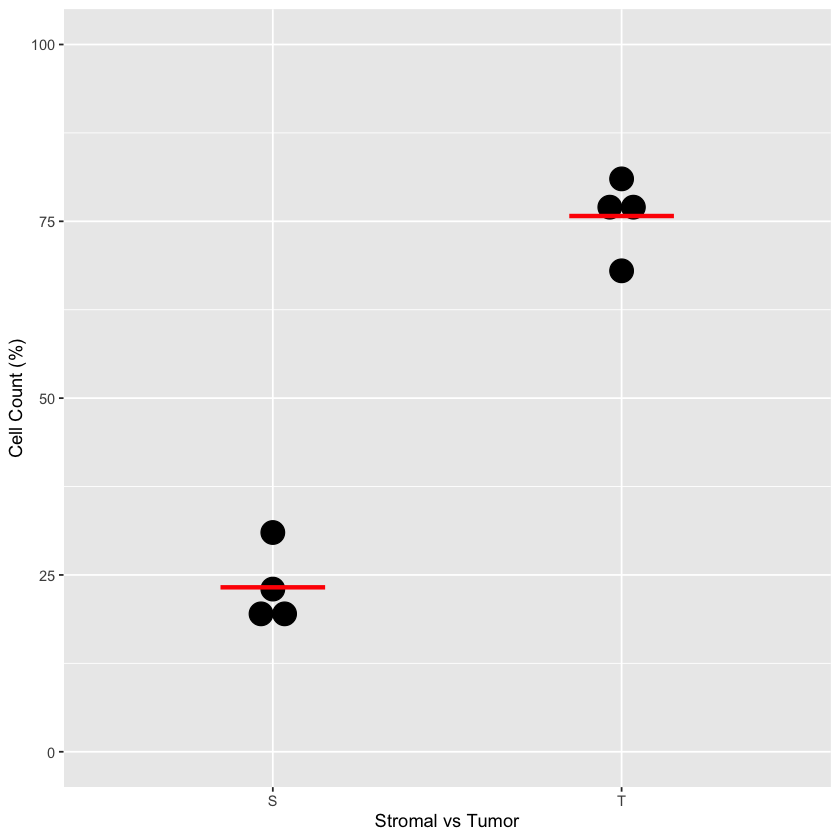

In [ ]:
ggplot(tumor.stromal.data.for.dotplot, aes(x=tumor.stromal, y=percent)) +
    geom_dotplot(binaxis='y', stackdir='center') +
    ylim(c(0, 100)) +
    stat_summary(
        fun=mean,
        geom="crossbar",
        size=0.5,
        width=0.3,
        color="red"
    ) +
    xlab("Stromal vs Tumor") +
    ylab("Cell Count (%)")

# <b style="color:#EB1960">Fig 5c</b>

> <b style="color:#EB1960">Fig 5c)</b> <b style="color:#537FBF">t-SNE plot</b> from a overlaid with <b style="color:#A6A440">XIST expression</b>
>
> Moreover, cells in two of the distinct clusters did not express <b style="color:#A6A440">XIST</b> (<b style="color:#EB1960">Fig. 5c</b>), consistent with loss of the <b style="color:#A6A440">inactive X chromosome</b>.
>
> -- What @ovarian-cancer-living-biobank has to say about <b style="color:#EB1960">Fig 5c</b>

[We can see](https://www.ensembl.org/Homo_sapiens/Gene/Ontologies/biological_process?g=ENSG00000229807;r=X:73820649-73852723) that <b style="color:#A6A440">XIST</b> is also known as <b style="color:#A6A440">ENSG00000229807</b>.

In [ ]:
any(rownames(ovarian.sce) == "ENSG00000229807")

[1] FALSE

But, uh, it's not in our dataset.  I even checked to see if we filtered it out, but its not there.  This is a fairly major issue.

Some replacement genes:

* <b style="color:#A6A440">JPX</b>: <b style="color:#A6A440">ENSG00000225470</b>
* <b style="color:#A6A440">FTX</b>: <b style="color:#A6A440">ENSG00000230590</b>
* <b style="color:#A6A440">TSIX</b>: <b style="color:#A6A440">ENSG00000270641</b>
* <b style="color:#A6A440">EPCAM</b>: <b style="color:#A6A440">ENSG00000119888</b>
* <b style="color:#A6A440">TP53</b>: <b style="color:#A6A440">ENSG00000141510</b>
* <b style="color:#A6A440">MYC</b>: <b style="color:#A6A440">ENSG00000136997</b>

I found some of these by picking apart this quote referring to <b style="color:#EB1960">Fig 4</b>:

> This classification was supported by interrogating specific genes, with the tumour cells expressing <b style="color:#A6A440">EPCAM</b>, <b style="color:#A6A440">TP53</b> and <b style="color:#A6A440">MYC</b> but negative for <b style="color:#A6A440">XIST</b> and <b style="color:#A6A440">TSIX</b>, consistent with loss of the inactive X chromosome (<b style="color:#EB1960">Fig. 4c</b>)

And the rest from [wikipedia](https://en.wikipedia.org/wiki/XIST).

In [ ]:
any(rownames(ovarian.sce) == "ENSG00000225470")
any(rownames(ovarian.sce) == "ENSG00000230590")
any(rownames(ovarian.sce) == "ENSG00000270641")
any(rownames(ovarian.sce) == "ENSG00000119888")
any(rownames(ovarian.sce) == "ENSG00000141510")
any(rownames(ovarian.sce) == "ENSG00000136997")

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] TRUE

[1] FALSE

So it seems like, of the data the genes they claim to have been looking at, only one of them is actually in their dataset.  I'm sure I'm missing something here, but there's not much I can do about it.  The description of <b style="color:#A6A440">TP53</b> is "tumor protein p53" according to <b style="color:#EB1960">Ensembl</b>, so it certainly seems relevant!

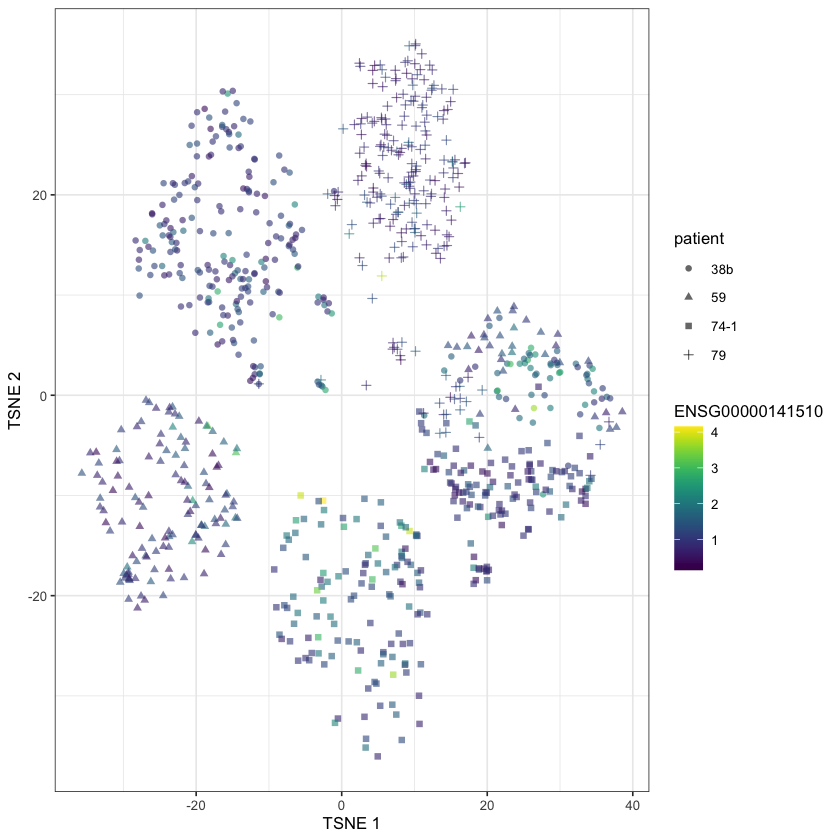

In [ ]:
# Removed all zero counts to prevent clutter
plotReducedDim(
    ovarian.sce[,which(assay(ovarian.sce, "counts")["ENSG00000141510",] > 0)],
    "TSNE",
    colour_by="ENSG00000141510",
    shape_by="patient"
)

We can see nothing informative here, it seems.

Maybe we can salvage a pretty graph by looking at the famous <b style="color:#A6A440">BRCA1</b> (<b style="color:#A6A440">ENSG00000012048</b>) gene?

In [ ]:
any(rownames(ovarian.sce) == "ENSG00000012048")

[1] FALSE

No^[In their defence, <b style="color:#A6A440">BRCA1</b> is actually in the dataset, it just got filtered out before we got here.].

# Going Offscript

The fact that <b style="color:#A6A440">XIST</b> does not exist is quite annoying.  Let's find another marker gene to get a pretty plot!

In [ ]:
ovarian.sce

class: SingleCellExperiment 
dim: 6454 18757 
metadata(0):
assays(2): counts logcounts
rownames(6454): ENSG00000000457 ENSG00000000460 ... ENSG00000288504
  ENSG00000288649
rowData names(0):
colnames(18757): SAMEA6492740-AAACCCACAGTTAGGG
  SAMEA6492740-AAACCCACATGTGTCA ... SAMEA6492743-TTTGTTGGTCCTGGTG
  SAMEA6492743-TTTGTTGTCAGATTGC
colData names(3): patient sizeFactor tumor.stromal.clusters
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):

In [ ]:
marker.info <- scran::scoreMarkers(ovarian.sce, ovarian.sce$tumor.stromal.clusters)

In [ ]:
# We should pick a marker for cluster 1,
# because its the only stromal cell cluster
# so we should expect it to have clearly differentially expressed genes.
chosen <- marker.info[["1"]]
rownames(ovarian.sce)[order(chosen$mean.AUC, decreasing=TRUE)[[1]]]

[1] "ENSG00000106366"

<b style="color:#A6A440">ENSG00000106366</b> is also known as <b style="color:#A6A440">SERPINE1</b>, which is kinda cool.

In [ ]:
# For pretty display, let's label each cluster as either
# tumor or stromal
ovarian.sce$tumor.or.stromal <- "Unspecified"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters == 1] <- "Stromal Cell"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters == 2] <- "Tumor Cell (1)"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters == 3] <- "Tumor Cell (2)"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters == 4] <- "Tumor Cell (3)"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters == 5] <- "Tumor Cell (4)"
ovarian.sce

class: SingleCellExperiment 
dim: 6454 18757 
metadata(0):
assays(2): counts logcounts
rownames(6454): ENSG00000000457 ENSG00000000460 ... ENSG00000288504
  ENSG00000288649
rowData names(0):
colnames(18757): SAMEA6492740-AAACCCACAGTTAGGG
  SAMEA6492740-AAACCCACATGTGTCA ... SAMEA6492743-TTTGTTGGTCCTGGTG
  SAMEA6492743-TTTGTTGTCAGATTGC
colData names(4): patient sizeFactor tumor.stromal.clusters
  tumor.or.stromal
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):

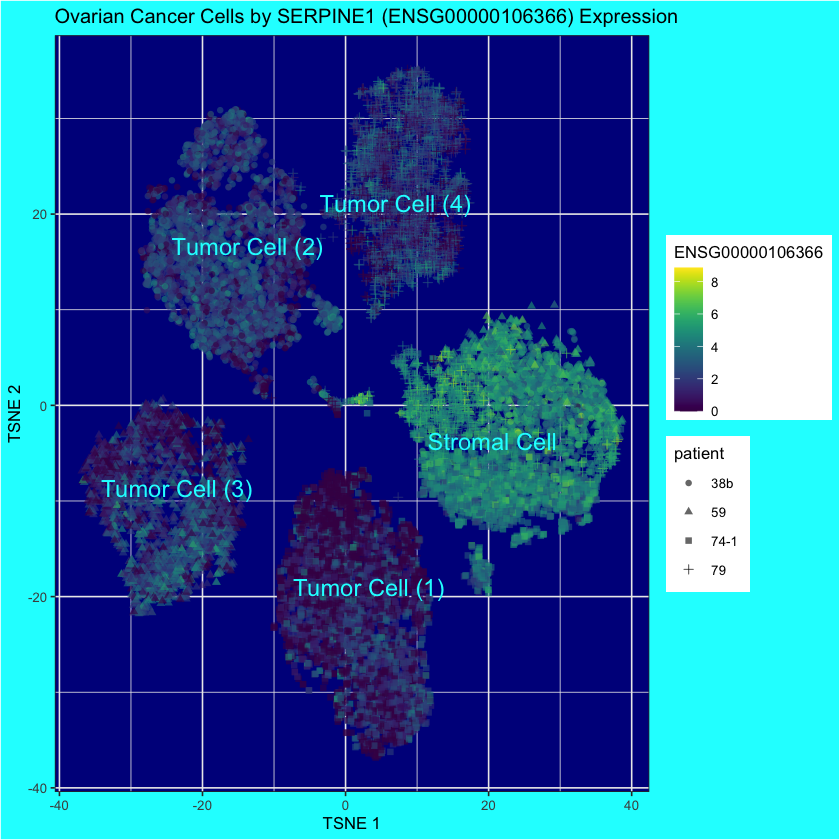

In [ ]:
plotReducedDim(
    ovarian.sce,
    "TSNE",
    colour_by="ENSG00000106366",
    shape_by="patient",
    text_by="tumor.or.stromal",
    text_colour="cyan"
) +
    ggtitle("Ovarian Cancer Cells by SERPINE1 (ENSG00000106366) Expression") +
    theme(
        panel.background = element_rect(fill = "darkblue"),
        plot.background = element_rect(fill = "cyan")
    )

This is quite a strong result!  Of course, it's a result that's already known:

> <b style="color:#A6A440">SERPINE1</b> has been proven to be the most reliable biological and prognostic marker for a variety of cancers, including <b style="color:#A6A440">breast cancer</b>, <b style="color:#A6A440">ovarian cancer</b>, <b style="color:#A6A440">bladder cancer</b>, <b style="color:#A6A440">colon cancer</b>, <b style="color:#A6A440">kidney cancer</b> and <b style="color:#A6A440">non-small cell lung cancer</b>.
>
> -- @SERPINE1

But still, it makes a nice plot.

My takeaways from these past two blog posts are:

* "Every cancer is unique" is not just a buzzphrase; the variation between cancers in different people is far greater than the variation between stromal cells between people
* <b style="color:#A6A440">SERPINE1</b> is a biomarker for cancer
* `SingleCellExperiment` is a nice way to group data
* <b style="color:#EB1960">Bioconductor</b> has amazing online resources and a nice suite of packages

I quite liked going offscript at the end.  I may delve further into <b style="color:#537FBF">differential expression</b> in the next blogpost, or I might take a look at <b style="color:#537FBF">16S rRNA sequencing</b>.  Not sure.